In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, abs, avg, lag, desc
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
spark = SparkSession.builder.appName('Stock Data').getOrCreate()

Loading file in dataframe

In [2]:
dataset = spark.read.csv('./Data/AMZN_data.csv', inferSchema=True, header=True)

In [3]:
dataset.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [4]:
dataset.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [5]:
dataset.show()

+----------+--------+--------+--------+--------+---------+----------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|
+----------+--------+--------+--------+--------+---------+----------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 318744000|
|1997-05-27|0.075521|0.082292|0.072917|0.079167| 0.079167| 173952000|
|1997-05-28| 0.08125|0.081771|0.076563|0.076563| 0.076563|  91488000|
|1997-05-29|0.077083|0.077083|0.073958| 0.07526|  0.07526|  69456000|
|1997-05-30|   0.075|0.075521|0.073958|   0.075|    0.075|  51888000|
|1997-06-02|0.075521

In [6]:
null_checks = [count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]
dataset.select(null_checks).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



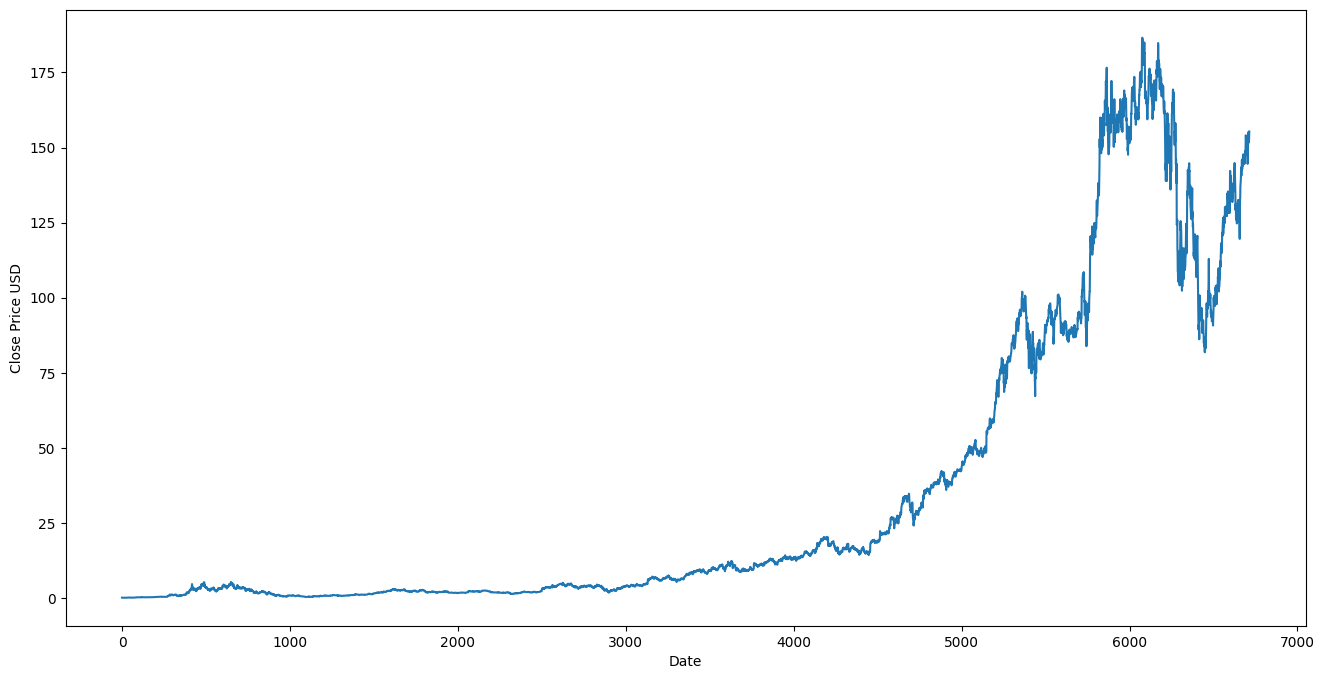

In [7]:
pandas_df = dataset.select('Date', 'Close').toPandas()
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df['Close'])
plt.show()

In [8]:
future_days=30
windowSpec = Window.orderBy("Date")
dataset = dataset.withColumn("Future_close", lag("Close", -future_days).over(windowSpec))
dataset.show(5)

+----------+--------+--------+--------+--------+---------+----------+------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|Future_close|
+----------+--------+--------+--------+--------+---------+----------+------------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|    0.074479|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|    0.077083|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|    0.075781|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|    0.079427|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|    0.095573|
+----------+--------+--------+--------+--------+---------+----------+------------+
only showing top 5 rows



In [9]:
dataset.orderBy(desc("Date")).show(5)

+----------+----------+----------+----------+----------+----------+--------+------------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Future_close|
+----------+----------+----------+----------+----------+----------+--------+------------+
|2024-01-19|153.830002|155.759995|152.740005|155.339996|155.339996|51033700|        NULL|
|2024-01-18|152.770004|153.779999|151.820007|     153.5|     153.5|37850200|        NULL|
|2024-01-17|151.490005|152.149994|149.910004|151.710007|151.710007|34953400|        NULL|
|2024-01-16|153.529999|154.990005|152.149994|153.160004|153.160004|41384600|        NULL|
|2024-01-12|155.389999|156.199997|154.009995|154.619995|154.619995|40460300|        NULL|
+----------+----------+----------+----------+----------+----------+--------+------------+
only showing top 5 rows



In [10]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [11]:
featureassembler=VectorAssembler(inputCols=["Open", "High", "Low"], outputCol='Features')

In [12]:
output=featureassembler.transform(dataset)

In [13]:
null_checks = [count(when(col(c).isNull(), c)).alias(c) for c in output.columns]
output.select(null_checks).show()

+----+----+----+---+-----+---------+------+------------+--------+
|Date|Open|High|Low|Close|Adj Close|Volume|Future_close|Features|
+----+----+----+---+-----+---------+------+------------+--------+
|   0|   0|   0|  0|    0|        0|     0|          30|       0|
+----+----+----+---+-----+---------+------+------------+--------+



In [14]:
output = output.na.drop()

In [15]:
output.show()

+----------+--------+--------+--------+--------+---------+----------+------------+--------------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|Future_close|            Features|
+----------+--------+--------+--------+--------+---------+----------+------------+--------------------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|    0.074479|[0.121875,0.125,0...|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|    0.077083|[0.098438,0.09895...|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|    0.075781|[0.088021,0.08854...|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|    0.079427|[0.086458,0.0875,...|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|    0.095573|[0.081771,0.08229...|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|         0.1|[0.071875,0.07239...|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 31874

In [16]:
output.select(['Features']).show()

+--------------------+
|            Features|
+--------------------+
|[0.121875,0.125,0...|
|[0.098438,0.09895...|
|[0.088021,0.08854...|
|[0.086458,0.0875,...|
|[0.081771,0.08229...|
|[0.071875,0.07239...|
|[0.070313,0.07604...|
|[0.075521,0.08229...|
|[0.08125,0.081771...|
|[0.077083,0.07708...|
|[0.075,0.075521,0...|
|[0.075521,0.07656...|
|[0.076563,0.07656...|
|[0.073958,0.07447...|
|[0.070833,0.07708...|
|[0.075781,0.08541...|
|[0.082813,0.08541...|
|[0.085417,0.08541...|
|[0.079688,0.08020...|
|[0.079167,0.08229...|
+--------------------+
only showing top 20 rows



In [17]:
output.columns

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Future_close',
 'Features']

In [18]:
final_data=output.select("Date", "Features", "Close", "Future_Close").sort("Date", ascending=True)

In [19]:
final_data.show()

+----------+--------------------+--------+------------+
|      Date|            Features|   Close|Future_Close|
+----------+--------------------+--------+------------+
|1997-05-15|[0.121875,0.125,0...|0.097917|    0.074479|
|1997-05-16|[0.098438,0.09895...|0.086458|    0.077083|
|1997-05-19|[0.088021,0.08854...|0.085417|    0.075781|
|1997-05-20|[0.086458,0.0875,...|0.081771|    0.079427|
|1997-05-21|[0.081771,0.08229...|0.071354|    0.095573|
|1997-05-22|[0.071875,0.07239...|0.069792|         0.1|
|1997-05-23|[0.070313,0.07604...|   0.075|    0.115104|
|1997-05-27|[0.075521,0.08229...|0.079167|    0.116146|
|1997-05-28|[0.08125,0.081771...|0.076563|    0.128125|
|1997-05-29|[0.077083,0.07708...| 0.07526|    0.114583|
|1997-05-30|[0.075,0.075521,0...|   0.075|    0.106771|
|1997-06-02|[0.075521,0.07656...|0.075521|    0.121875|
|1997-06-03|[0.076563,0.07656...|0.073958|    0.116667|
|1997-06-04|[0.073958,0.07447...|0.070833|    0.110938|
|1997-06-05|[0.070833,0.07708...|0.077083|    0.

In [20]:
train_data, test_data=final_data.randomSplit([0.75,0.25])
print(f"""There are {train_data.count()} rows in the trainning set,
      and {test_data.count()} in the test set""")

There are 5043 rows in the trainning set,
      and 1641 in the test set


Linear Regression model

In [21]:
from pyspark.ml.regression import LinearRegression

In [22]:
regressor=LinearRegression(featuresCol='Features', labelCol='Future_Close')
lr_model=regressor.fit(train_data)

In [23]:
lr_model.coefficients

DenseVector([-0.4662, 0.8125, 0.6565])

In [24]:
lr_model.intercept

0.5632960689076874

Test

In [25]:
pred_test1=lr_model.transform(test_data)
pred_test1.select("Features", "Close", "Future_Close", "Prediction").show(30)

+--------------------+--------+------------+------------------+
|            Features|   Close|Future_Close|        Prediction|
+--------------------+--------+------------+------------------+
|[0.098438,0.09895...|0.086458|    0.077083|0.6538873725084748|
|[0.071875,0.07239...|0.069792|         0.1|0.6316951676753124|
|[0.075521,0.08229...|0.079167|    0.116146|0.6428232841721719|
|[0.08125,0.081771...|0.076563|    0.128125|0.6421229740110259|
|[0.075,0.075521,0...|   0.075|    0.106771|0.6382483126543887|
|[0.076563,0.07656...|0.073958|    0.116667|0.6383662757152012|
|[0.070833,0.07708...|0.077083|    0.107813|0.6380407219128384|
|[0.085417,0.08541...|0.079167|    0.114583|0.6431427006111373|
|[0.080208,0.08020...|0.078646|    0.123958| 0.642364344897324|
|[0.076042,0.07682...|0.075521|    0.119792|0.6395045179073435|
|[0.076302,0.07630...|0.075521|    0.108854|0.6386179496501689|
|[0.075521,0.07994...|0.077083|    0.109896|0.6416022872178069|
|[0.075781,0.07968...|0.079427|    0.107

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

In [27]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Future_Close", metricName="mse")
mse = evaluator.evaluate(pred_test1)
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Future_Close", metricName="r2")
r2 = evaluator_r2.evaluate(pred_test1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  34.392804099657134 
r2:  0.9853907483555714 



In [28]:
pred_test1=pred_test1.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  30.480291081244598


In [29]:
pandas_df1 = pred_test1.select("Close", "Future_Close", "Prediction").toPandas()

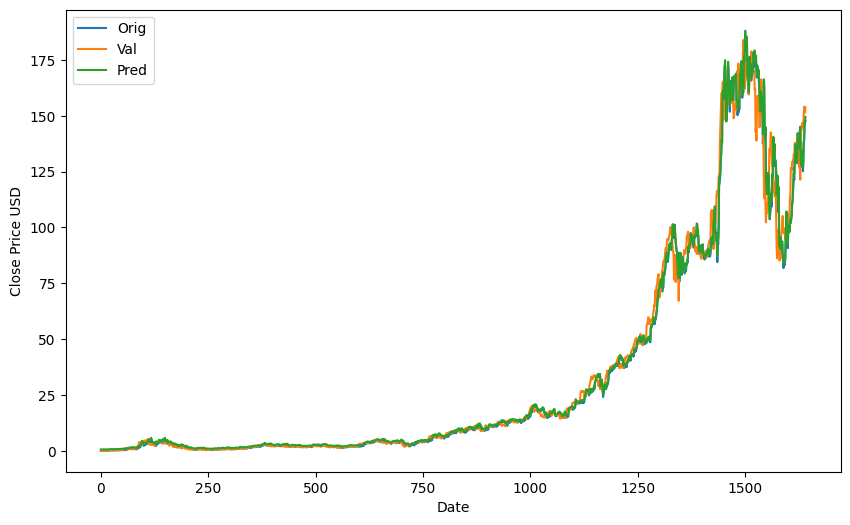

In [30]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df1['Close'])
plt.plot(pandas_df1[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [31]:
pred_train1=lr_model.transform(train_data)
pred_train1.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+------------------+
|            Features|   Close|Future_Close|        Prediction|
+--------------------+--------+------------+------------------+
|[0.121875,0.125,0...|0.097917|    0.074479|0.6713006981466694|
|[0.088021,0.08854...|0.085417|    0.075781|0.6475449765266587|
|[0.086458,0.0875,...|0.081771|    0.079427|0.6477690715343611|
|[0.081771,0.08229...|0.071354|    0.095573|0.6371738380338297|
|[0.070313,0.07604...|   0.075|    0.115104|0.6360697676694226|
|[0.077083,0.07708...| 0.07526|    0.114583|0.6385463513835712|
|[0.075521,0.07656...|0.075521|    0.121875| 0.639536153601535|
|[0.073958,0.07447...|0.070833|    0.110938|0.6351523172536009|
|[0.075781,0.08541...|0.082813|    0.109115|0.6469507151999146|
|[0.082813,0.08541...|0.084375|    0.106771|0.6484600225416791|
|[0.079688,0.08020...|0.077083|    0.113021|0.6415812419257282|
|[0.079167,0.08229...|0.080208|    0.111458|0.6442007937655482|
|[0.08125,0.08125,...|0.079167|    0.116

In [32]:
mse = evaluator.evaluate(pred_train1)
r2 = evaluator_r2.evaluate(pred_train1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  44.50121198308861 
r2:  0.9828668865191408 



In [33]:
pred_train1=pred_train1.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  31.11435444005298


In [34]:
pandas_df1 = pred_train1.select("Close", "Future_Close", "Prediction").toPandas()

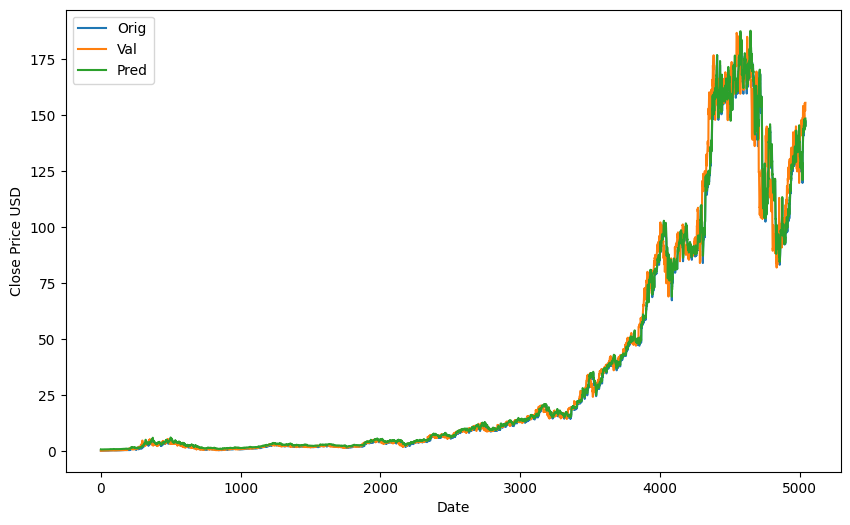

In [35]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df1['Close'])
plt.plot(pandas_df1[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Random Forest Regressor model

In [36]:
from pyspark.ml.regression import RandomForestRegressor

In [37]:
rf=RandomForestRegressor(featuresCol='Features', labelCol='Close')
rf_model=rf.fit(train_data)

Test

In [38]:
pred_test2=rf_model.transform(test_data)
pred_test2.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+------------------+
|            Features|   Close|Future_Close|        Prediction|
+--------------------+--------+------------+------------------+
|[0.098438,0.09895...|0.086458|    0.077083|0.6854477264533488|
|[0.071875,0.07239...|0.069792|         0.1|0.6854477264533488|
|[0.075521,0.08229...|0.079167|    0.116146|0.6854477264533488|
|[0.08125,0.081771...|0.076563|    0.128125|0.6854477264533488|
|[0.075,0.075521,0...|   0.075|    0.106771|0.6854477264533488|
|[0.076563,0.07656...|0.073958|    0.116667|0.6854477264533488|
|[0.070833,0.07708...|0.077083|    0.107813|0.6854477264533488|
|[0.085417,0.08541...|0.079167|    0.114583|0.6854477264533488|
|[0.080208,0.08020...|0.078646|    0.123958|0.6854477264533488|
|[0.076042,0.07682...|0.075521|    0.119792|0.6854477264533488|
|[0.076302,0.07630...|0.075521|    0.108854|0.6854477264533488|
|[0.075521,0.07994...|0.077083|    0.109896|0.6854477264533488|
|[0.075781,0.07968...|0.079427|    0.107

In [39]:
mse = evaluator.evaluate(pred_test2)
r2 = evaluator_r2.evaluate(pred_test2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  37.699047763297756 
r2:  0.9839863340618149 



In [40]:
pred_test2=pred_test2.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  21.832185360852918


In [41]:
pandas_df2 = pred_test2.select("Close", "Future_Close", "Prediction").toPandas()

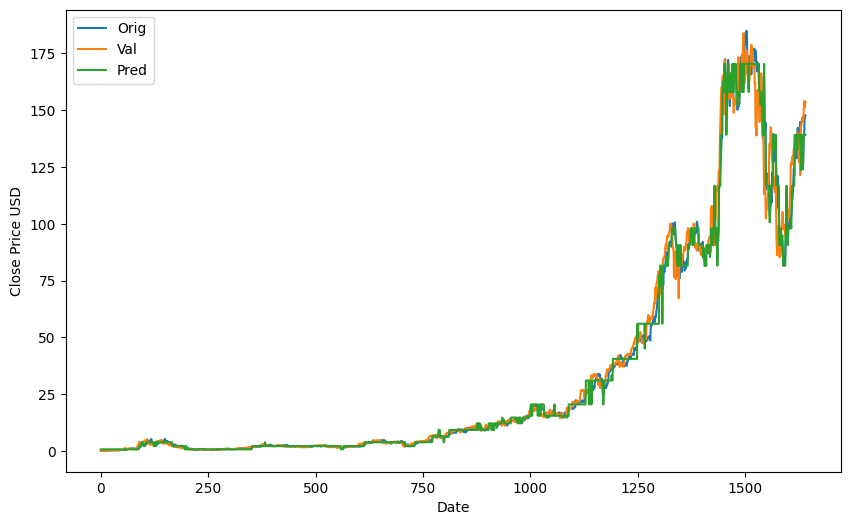

In [42]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df2['Close'])
plt.plot(pandas_df2[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [43]:
pred_train2=rf_model.transform(train_data)
pred_train2.select("Features", "Close", "Future_Close", "Prediction").show()

+--------------------+--------+------------+------------------+
|            Features|   Close|Future_Close|        Prediction|
+--------------------+--------+------------+------------------+
|[0.121875,0.125,0...|0.097917|    0.074479|0.6854477264533488|
|[0.088021,0.08854...|0.085417|    0.075781|0.6854477264533488|
|[0.086458,0.0875,...|0.081771|    0.079427|0.6854477264533488|
|[0.081771,0.08229...|0.071354|    0.095573|0.6854477264533488|
|[0.070313,0.07604...|   0.075|    0.115104|0.6854477264533488|
|[0.077083,0.07708...| 0.07526|    0.114583|0.6854477264533488|
|[0.075521,0.07656...|0.075521|    0.121875|0.6854477264533488|
|[0.073958,0.07447...|0.070833|    0.110938|0.6854477264533488|
|[0.075781,0.08541...|0.082813|    0.109115|0.6854477264533488|
|[0.082813,0.08541...|0.084375|    0.106771|0.6854477264533488|
|[0.079688,0.08020...|0.077083|    0.113021|0.6854477264533488|
|[0.079167,0.08229...|0.080208|    0.111458|0.6854477264533488|
|[0.08125,0.08125,...|0.079167|    0.116

In [44]:
mse = evaluator.evaluate(pred_train2)
r2 = evaluator_r2.evaluate(pred_train2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  52.63420552796675 
r2:  0.9797356571630405 



In [45]:
pred_train2=pred_train2.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  22.829947655452905


In [46]:
pandas_df2 = pred_train2.select("Close", "Future_Close", "Prediction").toPandas()

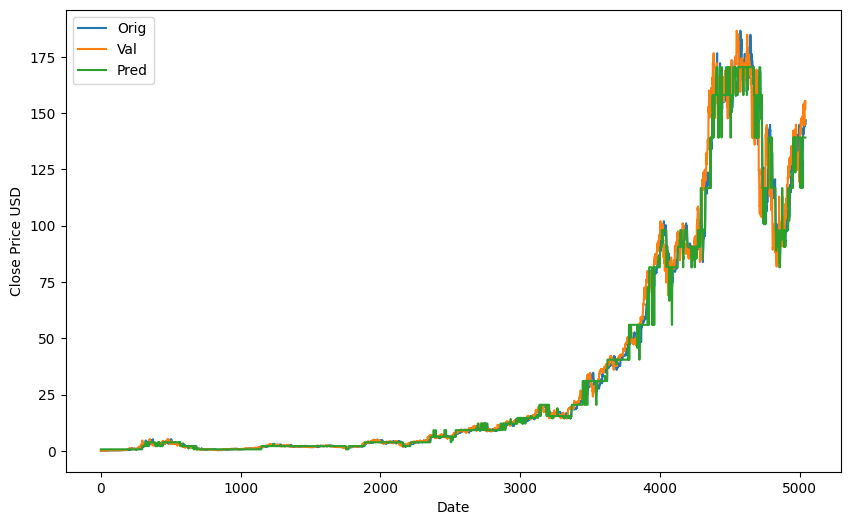

In [47]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df2['Close'])
plt.plot(pandas_df2[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Gradient-Boosted Tree Regression

In [48]:
from pyspark.ml.regression import GBTRegressor

In [49]:
gbt = GBTRegressor(featuresCol='Features', labelCol='Future_Close', maxIter=10)
gbt_model = gbt.fit(train_data)

In [50]:
pred_test3=gbt_model.transform(test_data)
pred_test3.select("Features", "Close", "Future_Close", "Prediction").show(truncate=False)

+----------------------------+--------+------------+-------------------+
|Features                    |Close   |Future_Close|Prediction         |
+----------------------------+--------+------------+-------------------+
|[0.098438,0.098958,0.085417]|0.086458|0.077083    |0.33163764904650056|
|[0.071875,0.072396,0.065625]|0.069792|0.1         |0.33163764904650056|
|[0.075521,0.082292,0.072917]|0.079167|0.116146    |0.33163764904650056|
|[0.08125,0.081771,0.076563] |0.076563|0.128125    |0.33163764904650056|
|[0.075,0.075521,0.073958]   |0.075   |0.106771    |0.33163764904650056|
|[0.076563,0.076563,0.073958]|0.073958|0.116667    |0.33163764904650056|
|[0.070833,0.077083,0.06875] |0.077083|0.107813    |0.33163764904650056|
|[0.085417,0.085417,0.076563]|0.079167|0.114583    |0.33163764904650056|
|[0.080208,0.080208,0.078125]|0.078646|0.123958    |0.33163764904650056|
|[0.076042,0.076823,0.075]   |0.075521|0.119792    |0.33163764904650056|
|[0.076302,0.076302,0.074479]|0.075521|0.108854    

In [51]:
mse = evaluator.evaluate(pred_test3)
r2 = evaluator_r2.evaluate(pred_test3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  34.16779716955217 
r2:  0.985486325990187 



In [52]:
pred_test3=pred_test3.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_test3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  15.580203107073128


In [53]:
pandas_df3 = pred_test3.select("Close", "Future_Close", "Prediction").toPandas()

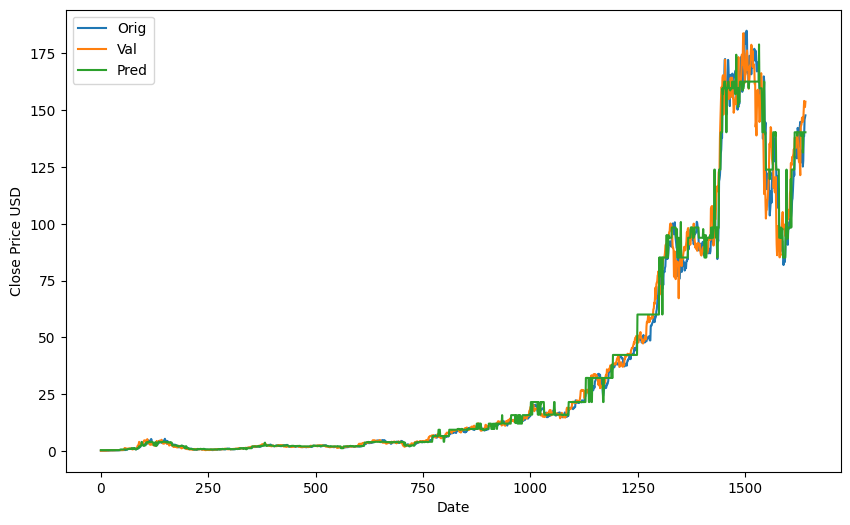

In [54]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df3['Close'])
plt.plot(pandas_df3[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Train

In [55]:
pred_train3=gbt_model.transform(train_data)
pred_train3.select("Features", "Close", "Future_Close", "Prediction").show(truncate=False)

+----------------------------+--------+------------+-------------------+
|Features                    |Close   |Future_Close|Prediction         |
+----------------------------+--------+------------+-------------------+
|[0.121875,0.125,0.096354]   |0.097917|0.074479    |0.33163764904650056|
|[0.088021,0.088542,0.08125] |0.085417|0.075781    |0.33163764904650056|
|[0.086458,0.0875,0.081771]  |0.081771|0.079427    |0.33163764904650056|
|[0.081771,0.082292,0.06875] |0.071354|0.095573    |0.33163764904650056|
|[0.070313,0.076042,0.066667]|0.075   |0.115104    |0.33163764904650056|
|[0.077083,0.077083,0.073958]|0.07526 |0.114583    |0.33163764904650056|
|[0.075521,0.076563,0.075]   |0.075521|0.121875    |0.33163764904650056|
|[0.073958,0.074479,0.069792]|0.070833|0.110938    |0.33163764904650056|
|[0.075781,0.085417,0.075521]|0.082813|0.109115    |0.33163764904650056|
|[0.082813,0.085417,0.082813]|0.084375|0.106771    |0.33163764904650056|
|[0.079688,0.080208,0.076563]|0.077083|0.113021    

In [56]:
mse = evaluator.evaluate(pred_train3)
r2 = evaluator_r2.evaluate(pred_train3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  46.066487916479474 
r2:  0.9822642501189044 



In [57]:
pred_train3=pred_train3.withColumn("MAPE",abs(col("Future_Close")-col("Prediction"))/col("Future_Close"))
mape = pred_train3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  15.51883544221371


In [58]:
pandas_df3 = pred_train3.select("Close", "Future_Close", "Prediction").toPandas()

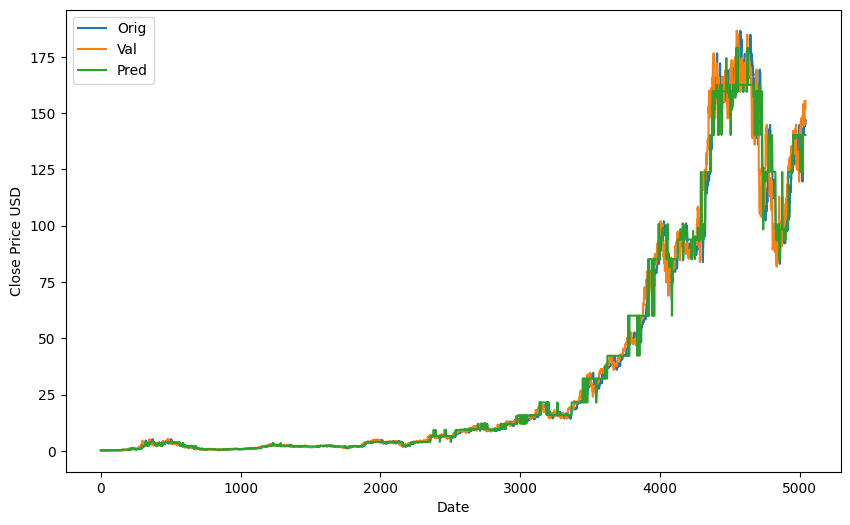

In [59]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df3['Close'])
plt.plot(pandas_df3[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

Linear Regression model

In [60]:
pandas_df = pred_train1.select("Close", "Future_Close", "Prediction").toPandas()

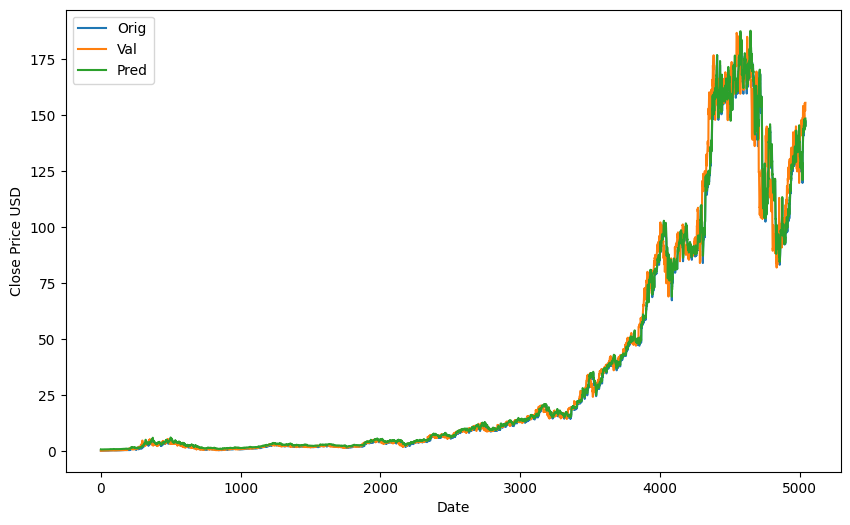

In [61]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(pandas_df['Close'])
plt.plot(pandas_df[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.show()

In [62]:
# lr_model.write().save("Model")

SONY

In [63]:
data = spark.read.csv('./Data/SONY.csv', inferSchema=True, header=True)
data.show()

+----------+---------+---------+---------+---------+---------+-------+
|      Date|     Open|     High|      Low|    Close|Adj Close| Volume|
+----------+---------+---------+---------+---------+---------+-------+
|2012-02-02|    17.65|    17.68|    16.85|    17.09|    17.09|3934600|
|2012-02-03|    18.85|    19.32|18.790001|19.209999|19.209999|4453500|
|2012-02-06|19.360001|19.459999|19.280001|19.440001|19.440001|1322700|
|2012-02-07|19.639999|19.709999|    19.16|    19.68|    19.68|1664400|
|2012-02-08|19.790001|    20.01|19.780001|19.889999|19.889999|1195500|
|2012-02-09|19.940001|     20.0|19.799999|    19.91|    19.91| 885200|
|2012-02-10|19.690001|19.690001|    19.41|19.530001|19.530001|1751000|
|2012-02-13|19.559999|    19.58|19.389999|    19.48|    19.48| 809600|
|2012-02-14|    19.23|    19.23|     19.0|19.129999|19.129999|1245600|
|2012-02-15|19.969999|    20.15|19.950001|    19.99|    19.99|2194900|
|2012-02-16|20.209999|    20.52|20.209999|     20.5|     20.5|1319500|
|2012-

In [64]:
future_days=15
windowSpec = Window.orderBy("Date")
data = data.withColumn("Future_close", lag("Close", -future_days).over(windowSpec))

In [65]:
featureassembler=VectorAssembler(inputCols=["Open", "High", "Low"], outputCol='Features')
data=featureassembler.transform(data)
data = data.na.drop()

In [66]:
sony_prediction=lr_model.transform(data)
sony_prediction.show()

+----------+---------+---------+---------+---------+---------+-------+------------+--------------------+------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close| Volume|Future_close|            Features|        prediction|
+----------+---------+---------+---------+---------+---------+-------+------------+--------------------+------------------+
|2012-02-02|    17.65|    17.68|    16.85|    17.09|    17.09|3934600|       21.73| [17.65,17.68,16.85]|17.762576817896264|
|2012-02-03|    18.85|    19.32|18.790001|19.209999|19.209999|4453500|   21.690001|[18.85,19.32,18.7...|19.809318865698284|
|2012-02-06|19.360001|19.459999|19.280001|19.440001|19.440001|1322700|       22.26|[19.360001,19.459...| 20.00701740552543|
|2012-02-07|19.639999|19.709999|    19.16|    19.68|    19.68|1664400|   21.389999|[19.639999,19.709...| 20.00082209108278|
|2012-02-08|19.790001|    20.01|19.780001|19.889999|19.889999|1195500|       21.57|[19.790001,20.01,...|20.581695418522155|
|2012-02

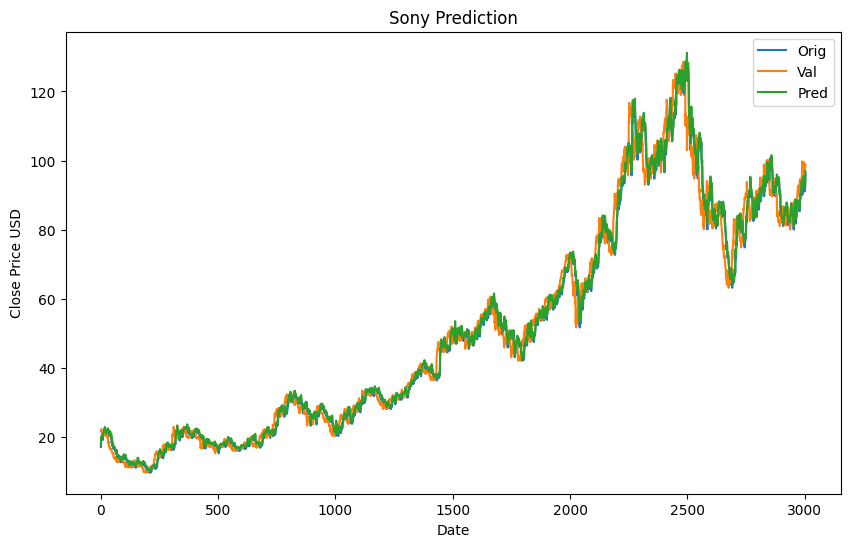

In [67]:
sony_prediction = sony_prediction.select("Close", "Future_Close", "Prediction").toPandas()
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(sony_prediction['Close'])
plt.plot(sony_prediction[['Future_Close', 'Prediction']])
plt.legend(['Orig', 'Val', 'Pred'])
plt.title('Sony Prediction')
plt.show()